In [1]:
# import functions
# version 2: did not use imputation. just ML directly 

# parameters:

import pandas as pd
import numpy as np
import codecs
import matplotlib.pyplot as plt
from IPython.display import SVG
from IPython.display import Image
import random
import csv

import datetime
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from dateutil.parser import parse
#from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute
from sklearn.preprocessing import StandardScaler                 #normalising features
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Lasso
from sklearn.svm import SVC, SVR

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
#from sknn import mlp

from scipy.optimize import minimize

import theano
import theano.tensor as T

%matplotlib inline

np.random.seed=10


In [2]:
import matplotlib.pyplot as plt

from py4j.java_gateway import JavaGateway

In [3]:
%matplotlib inline

# set up connection

In [4]:
gw = JavaGateway() # New gateway connection
bridge = gw.entry_point

# load netlogo model

In [5]:
# Path to the model:
models_path = "D:/Work/PhD/Github/NetLogoModel/"
model_name = "PhD_InitialModelV3.nlogo"

In [6]:
modelLocation = models_path + model_name

In [7]:
modelLocation

'D:/Work/PhD/Github/NetLogoModel/PhD_InitialModelV3.nlogo'

In [8]:
bridge.openModel(modelLocation)

# Run one iteration of the model, one command at a time:

In [ ]:
bridge.command("set grid-size 21")
bridge.command("set nb-people 1")
bridge.command("set Show_Names_Nodes? False")
bridge.command("set Show_Names_people? False")
bridge.command("set car-speed 1")
bridge.command("set mobiletowerdata? True")
bridge.command("set socialmedia_data? True")
bridge.command("set grids_covered_vector 10")
bridge.command("set avg_num_calls_perday 100")
bridge.command("set avg_call_duration_mins 2")

bridge.command("random-seed 0")
bridge.command("setup")
bridge.command("repeat 1440 [go]")

In [ ]:
bridge.command("repeat 144000 [go]")

# Have the model report results

In [ ]:
!head -n 15 ./agentdata.txt

In [ ]:
!head -n 15 ./mobiletowers.txt

In [9]:
# initiating the netlogo model
# and run it for the first 10 days
def model_init(ini_mins):
    bridge.command("set grid-size 21")
    bridge.command("set nb-people 1")
    bridge.command("set Show_Names_Nodes? False")
    bridge.command("set Show_Names_people? False")
    bridge.command("set car-speed 1")
    bridge.command("set mobiletowerdata? True")
    bridge.command("set socialmedia_data? True")
    bridge.command("set grids_covered_vector 5")
    bridge.command("set avg_num_calls_perday 10")            #setting for the usage of mobile phones
    bridge.command("set avg_call_duration_mins 2")
    bridge.command("set avg_num_sm_usage 5")                 #setting for the usage of social media
    bridge.command("random-seed 0")
    bridge.command("setup")
    bridge.command("repeat " + str(ini_mins) + " [go]")
    

In [10]:
def Schedule_Gen(population, CV, day_num):
    # generate population and schedules
    if CV == 0:
        CV = 0.000001
    pop_num = range(population)
    type_num = 1    # type of the person being generated: 1: full time employment
    #day_num = 100   # number of days to be simulated

    # assuming the following schedule sequence:
    mu_Wmorning = 450 #time to go out (7:30)
    sigma_Wmorning = mu_Wmorning*CV #standard deviation of morning trip
    mu_Wnoon = 210 #duration of morning work
    sigma_Wnoon = mu_Wnoon*CV #standard deviation of the duration of morning work
    mu_L = 60 # duration of lunch break
    sigma_L = mu_L*CV #standard deviation of the duration of lunch break
    mu_Wafnoon = 270 #duration of afternoon work
    sigma_Wafnoon = mu_Wafnoon*CV #standard deviation of the duration of morning work

    trip_Wmorning = [int(x) for x in np.random.normal(mu_Wmorning, sigma_Wmorning, day_num)] #generate start time based on normal distribution
    trip_Wnoon = [int(x) for x in np.random.normal(mu_Wnoon, sigma_Wnoon, day_num)] # work duration in the morning
    trip_Wafnoon = [int(x) for x in np.random.normal(mu_Wafnoon, sigma_Wafnoon, day_num)] #work duration in the afternoon
    trip_L = [int(x) for x in np.random.normal(mu_L, sigma_L, day_num)] #lunch break in the noon
    trip_Smorning = [int(x) for x in np.random.normal(mu_L, sigma_L, day_num)] #school trip in the morning
    trip_Safnoon = [int(x) for x in np.random.normal(mu_L, sigma_L, day_num)] #school trip in the afternoon

    z_home = 'home'#15 #zone number for home
    z_work = 'work'#25 #zone for work
    z_shop = 'shopping'#35 #zone number for shopping
    z_school = 'school'#45 #zone number for school

    for y in pop_num:
        demand_data = pd.DataFrame(None)
        demand_data['id'] = range(day_num*1440) 
        demand_data['day_id'] = [int(x/ 1440) for x in demand_data['id']]
        demand_data['minute_id'] = demand_data['id'] % 1440
        base = datetime.datetime.strptime('2015-01-01 00:00',  '%Y-%m-%d %H:%M')
        datetime_list = [base + datetime.timedelta(minutes=x) for x in range(0, day_num*1440)]
        dow = [datetime.datetime.isoweekday(x) for x in datetime_list]
        hr = [x.hour for x in datetime_list]
        minu = [x.minute for x in datetime_list]
        demand_data['datetime'] = [datetime.datetime.strftime(x, '%Y-%m-%d %H:%M') for x in datetime_list]
        demand_data['dow'] = dow
        demand_data['hour'] = hr
        demand_data['minute'] = minu
        demand_data['pid'] = y
        demand_data['type'] = type_num
        demand_data['zone'] = None
        cur_day = None
        uni_day = np.unique(demand_data['day_id'])
        for i in uni_day:
            cur_min = demand_data['minute_id'][i]
            Sch_drop_S = trip_Wmorning[i]
            Sch_drop_E = trip_Wmorning[i] + trip_Smorning[i]
            Wrk_Mor_E = trip_Wmorning[i] + trip_Smorning[i] + trip_Wnoon[i]
            Shp_E = trip_Wmorning[i] + trip_Smorning[i] + trip_Wnoon[i] + trip_L[i]
            Wrk_Aft_E = trip_Wmorning[i] + trip_Smorning[i] + trip_Wnoon[i] + trip_L[i] + trip_Wafnoon[i]
            Sch_pik_E = trip_Wmorning[i] + trip_Smorning[i] + trip_Wnoon[i] + trip_L[i] + trip_Wafnoon[i] + trip_Safnoon[i]

            demand_data.set_value(demand_data['id'][demand_data['day_id'] == i][0:Sch_drop_S], 'zone', z_home)
            demand_data.set_value(demand_data['id'][demand_data['day_id'] == i][Sch_drop_S:Sch_drop_E], 'zone', z_school)
            demand_data.set_value(demand_data['id'][demand_data['day_id'] == i][Sch_drop_E:Wrk_Mor_E], 'zone', z_work)
            demand_data.set_value(demand_data['id'][demand_data['day_id'] == i][Wrk_Mor_E:Shp_E], 'zone', z_shop)
            demand_data.set_value(demand_data['id'][demand_data['day_id'] == i][Shp_E:Wrk_Aft_E], 'zone', z_work)
            demand_data.set_value(demand_data['id'][demand_data['day_id'] == i][Wrk_Aft_E:Sch_pik_E], 'zone', z_school)
            demand_data.set_value(demand_data['id'][demand_data['day_id'] == i][Sch_pik_E:], 'zone', z_home)
        demand_data['zone'].to_csv('ActivitySchedule_' + str(y) + '.csv', header = False)


In [11]:
# import simuated data
# using function as the file can be closed automatically
def rawimport(path, columnname):
    agentdata = pd.read_csv(path, delimiter=' ', header=None, names=columnname)
    agentdata = agentdata.drop(labels="todrop", axis=1)
    return agentdata


In [12]:
# run NL model; 
def run_NL(mob_call):
    bridge.command(mob_call)


In [13]:
def data_input(path_i, columnname_i):

    agentdata = rawimport(path_i, columnname_i)
    dt_stamp = [datetime.datetime.strptime(x,  '%Y-%m-%d %H:%M') for x in agentdata["acc_time"]]
    dow = [datetime.datetime.isoweekday(x) for x in dt_stamp]
    hr = [x.hour for x in dt_stamp]
    minu = [x.minute for x in dt_stamp]
    agentdata['dow'] = dow
    agentdata['hour'] = hr
    agentdata['minute'] = minu

    return (agentdata)

#     mobiledata_ML = mobiledata.drop('radius', axis = 1)
#     mobiledata_ML.drop('acc_time', axis=1, inplace=True)
#     mobiledata_ML.drop('acc_min', axis=1, inplace=True)
#     mobiledata_ML.drop('tid', axis=1, inplace=True)
#     mobiledata_ML.drop('txcor', axis=1, inplace=True)
#     mobiledata_ML.drop('tycor', axis=1, inplace=True)
    
#     agentdata.drop('acc_time', axis=1, inplace=True)
#     agentdata.drop('acc_min', axis=1, inplace=True)

    
#    return (agentdata, mobiledata_ML)


In [14]:
def data_adj (dataset, tobedropped):
    
    for i in tobedropped:
        dataset.drop(i, axis=1, inplace=True)
    
    return (dataset)

In [15]:
class ReturnedValue(object):
    def __init__(self, clf1, clf2, clf3, clf4):
        self.clf1 = clf1
        self.clf2 = clf2
        self.clf3 = clf3
        self.clf4 = clf4


In [16]:
def NL_ML(mobiledata_ML, day_new, traintest_pre):
    # prepare for ML
    
    # need to keep previous training/testing samples, otherwise results flactuates
    
    mobiledata_new = mobiledata_ML[mobiledata_ML['day']>=day_new]
    
    X_new = mobiledata_new.drop('tzone', axis=1)
    X_new = X_new.drop('day', axis=1)
    y_new = mobiledata_new['tzone']
    trainX_new, testX_new, trainY_new, testY_new = train_test_split(X_new, y_new, random_state = 10)
        
    trainX = pd.concat([traintest_pre[0], trainX_new])
    testX = pd.concat([traintest_pre[1], testX_new])
    trainY = pd.concat([traintest_pre[2], trainY_new])
    testY = pd.concat([traintest_pre[3], testY_new])
    
    X = mobiledata_ML.drop('tzone', axis=1)
    y = mobiledata_ML['tzone']
    
    # knn
    clf_knn = KNeighborsClassifier(n_neighbors=1).fit(trainX, trainY)
    pred_knn = clf_knn.predict(testX)
    #print roc_auc_score(testY, pred_knn)
    AC_knn = accuracy_score(testY, pred_knn)
    RC_knn = recall_score(testY, pred_knn, average=None).mean()
    CF_knn = mean_squared_error(testY, pred_knn)
#    CV_knn = cross_val_score(clf_knn, X, y, cv=3)
    ## using ridge regression
    clf_rdg = RidgeClassifier(alpha=1).fit(trainX,trainY)
    pred_rdg = clf_rdg.predict(testX)
    AC_rdg = accuracy_score(testY, pred_rdg)
    RC_rdg = recall_score(testY, pred_rdg, average=None).mean()  
    CF_rdg =  mean_squared_error(testY, pred_rdg)
#    CV_rdg = cross_val_score(clf_rdg, X, y, cv=3)
    ## using RF
    clf_rf = RandomForestClassifier(n_estimators=100, max_depth=100)
    clf_rf.fit(trainX, trainY)
    pred_rf = clf_rf.predict(testX)
    AC_rf = accuracy_score(testY, pred_rf)
    RC_rf = recall_score(testY, pred_rf, average=None).mean()   
    CF_rf = mean_squared_error(testY, pred_rf)
#    CV_rf = cross_val_score(clf_rf, X, y, cv=3)
    ## using GBDT
    clf_gb = GradientBoostingClassifier(n_estimators=100, max_depth=3)
    clf_gb.fit(trainX, trainY)
    pred_gb = clf_gb.predict(testX)
    AC_gb = accuracy_score(testY, pred_gb)
    RC_gb = recall_score(testY, pred_gb, average=None).mean()  
    CF_gb = mean_squared_error(testY, pred_gb)
#    CV_gb = cross_val_score(clf_gb, X, y, cv=3)

    ##using neural networks
    trainY_ = trainY.copy()
    trainY_[trainY_==15] = 0
    trainY_[trainY_==25] = 1
    trainY_[trainY_==35] = 2
    trainY_[trainY_==45] = 3
    
    pred, optimal_params = fit_predict_NN(trainX.values, trainY_.values, testX.values, [T.tanh]*2, [10, 5], 0.5)
    #roc_auc_score(testY_, pred)
    pred_ = pred.copy()
    pred_[pred==0] = 15
    pred_[pred==1] = 25
    pred_[pred==2] = 35
    pred_[pred==3] = 45
    AC_ANN = accuracy_score(testY, pred_)
    RC_ANN = recall_score(testY, pred_, average=None).mean()
    CF_ANN = mean_squared_error(testY, pred_)
    
    trained_clf = [clf_knn, clf_rdg, clf_rf, clf_gb, optimal_params]
#    trained_CV = [CV_knn, CV_rdg, CV_rf, CV_gb]
    trained_RC = [RC_knn, RC_rdg, RC_rf, RC_gb, RC_ANN]
    trained_CM = [CF_knn, CF_rdg, CF_rf, CF_gb, CF_ANN]
    trained_AC = [AC_knn, AC_rdg, AC_rf, AC_gb, AC_ANN]
    traintest = [trainX, testX, trainY, testY]
    
    return (trained_clf, trained_RC, trained_CM, trained_AC, traintest)

In [17]:
def pred_agent(trained_clf, agentdata, last_n, traintest_prev):
    last_minutes = last_n * (-1440)
    pred_X = pd.DataFrame(None)
    pred_X['pid'] = agentdata['pid'][last_minutes:]
    pred_X['tpid'] = 0
    pred_X = pd.concat([pred_X, agentdata[last_minutes:].iloc[:,-3:]], axis = 1)

#    pred_X['day'] = pred_X['day'] + 1
#    pred_X['acc_time'] = pred_X['acc_time'] + 1440
    pred_y = agentdata[last_minutes:].iloc[:,2]
    

    pred_knn = trained_clf[0].predict(pred_X)
    #print roc_auc_score(testY, pred_knn)
    knn_AC = accuracy_score(pred_y, pred_knn)
    knn_RC = recall_score(pred_y, pred_knn, average='macro')
    knn_CM = mean_squared_error(pred_y, pred_knn)

    ## using ridge regression
    pred_rdg = trained_clf[1].predict(pred_X)
    rdg_AC = accuracy_score(pred_y, pred_rdg)
    rdg_RC = recall_score(pred_y, pred_rdg, average='macro')  
    rdg_CM = mean_squared_error(pred_y, pred_rdg)

    ## using RF
    pred_rf = trained_clf[2].predict(pred_X)
    rf_AC = accuracy_score(pred_y, pred_rf)
    rf_RC = recall_score(pred_y, pred_rf, average='macro')  
    rf_CM = mean_squared_error(pred_y, pred_rf)

    ## using GBDT
    pred_gb = trained_clf[3].predict(pred_X)
    gb_AC = accuracy_score(pred_y, pred_gb)
    gb_RC = recall_score(pred_y, pred_gb, average='macro')  
    gb_CM = mean_squared_error(pred_y, pred_gb)
    
    ## using ANN
    pred_ann = predict_NN(pred_X.values, traintest_prev[3], [T.tanh]*2, [10, 5], trained_clf[4])
    pred_ann_ = pred_ann.copy()
    pred_ann_[pred_ann==0] = 15
    pred_ann_[pred_ann==1] = 25
    pred_ann_[pred_ann==2] = 35
    pred_ann_[pred_ann==3] = 45
    AC_ANN = accuracy_score(pred_y, pred_ann_)
    RC_ANN = recall_score(pred_y, pred_ann_, average='macro')
    CF_ANN = mean_squared_error(pred_y, pred_ann_)
    
    pr_RC = [knn_RC, rdg_RC, rf_RC, gb_RC, RC_ANN]
    pr_CM = [knn_CM, rdg_CM, rf_CM, gb_CM, CF_ANN]
    pr_AC = [knn_AC, rdg_AC, rf_AC, gb_AC, AC_ANN]
    pr_data = [pred_X, pred_y]

    return (pr_RC, pr_CM, pr_AC, pr_data)


In [18]:
# ANN - prediction only
def predict_NN(testX, train_y, activate_functions, hidden_layers, fittedpar):
    dim = testX.shape[1]
    dim_y = len(np.unique(train_y))
    param = T.vector()
    def activation(data_, parameter):
        n_previous = 0
        dim_previous = dim
        h = data_
        #going through hidden layers
        for n_hidden, func in zip(hidden_layers, activate_functions):
            N = dim_previous * n_hidden
            W_ = parameter[n_previous:n_previous + N].reshape((dim_previous, n_hidden))
            h = func(h.dot(W_))
            dim_previous = n_hidden
            n_previous += N

        # output     
        N = dim_previous * dim_y
        v_ = parameter[n_previous:n_previous + N].reshape((dim_previous, dim_y))
        output = h.dot(v_)
        n_previous += N
        return T.nnet.softmax(output), n_previous
    
    data = T.matrix()
#    compiled_activation = theano.function([data, param], activation(data, param)[0])
    
    prediction = T.argmax(activation(data, param)[0], axis=1)
    predict = theano.function([data, param], prediction)
    return predict(testX, fittedpar)
    

In [19]:
# artificial neural networks
def fit_predict_NN(trainX, trainY, testX, activate_functions, hidden_layers, reg_lambda):
    X_ = theano.shared(trainX, name='X')
    y_ = theano.shared(trainY, name='y')
    param = T.vector()
    dim = trainX.shape[1]
    num_examples = trainX.shape[0]
    dim_y = len(np.unique(trainY))
    def activation(data_, parameter):
        n_previous = 0
        dim_previous = dim
        h = data_
        #going through hidden layers
        for n_hidden, func in zip(hidden_layers, activate_functions):
            N = dim_previous * n_hidden
            W_ = parameter[n_previous:n_previous + N].reshape((dim_previous, n_hidden))
            h = func(h.dot(W_))
            dim_previous = n_hidden
            n_previous += N

        # output     
        N = dim_previous * dim_y
        v_ = parameter[n_previous:n_previous + N].reshape((dim_previous, dim_y))
        output = h.dot(v_)
        n_previous += N
        return T.nnet.softmax(output), n_previous

    y_hat, dim_W = activation(X_, param)
    # optimize
    #regularisation
    loss_reg = 1./num_examples * reg_lambda/2 * T.sum(T.sqr(param)) 
    #cost
    loss = T.nnet.categorical_crossentropy(y_hat, y_).mean() + loss_reg
    loss_function = theano.function([param], loss)
    loss_grad = theano.function([param], theano.grad(loss, param))
    
    result = minimize(loss_function, jac=loss_grad, x0=np.random.normal(size=activation(X_, param)[1]))
    optimal_params = result['x']
#    print result
#    forward_prop = theano.function([param], y_hat)
#    theano.printing.pydotprint(forward_prop, var_with_name_simple=True, compact=True, outfile='img/nn-theano-forward_prop.png', format='png')
#    SVG(theano.printing.pydotprint(forward_prop, var_with_name_simple=True, compact=True, return_image=True, format='svg'))

    # predict data
    data = T.matrix()
#    compiled_activation = theano.function([data, param], activation(data, param)[0])
    
    prediction = T.argmax(activation(data, param)[0], axis=1)
    predict = theano.function([data, param], prediction)
    return (predict(testX, optimal_params), optimal_params)

In [20]:
## run Netlogo and carryout ML

agent_num = 2 #define the number of agents to be simulated
counter = 0
ini_day = 0 # define the number of days to initiate the model (i.e. the original training data)

last_n = 1 # define the number of days to be left out from simulation data for testing purpose
tot_day = 100 # define the number of days to be simulated
sim_day = 1 # define for one simulation how many days to be simulated
#num_sim = 1440 # define the duration of simulation (in minutes)
CV_range = np.arange(0, 0.51, 0.02)

# setting data storage
Results_sum = np.zeros((len(CV_range), 2, 3, 5, tot_day)) # CV, TR/PR, RC/CM/AC, CLF, Days
agentdata_tot = {}
mobiledata_tot = {}
smdata_tot = {}
traintestsplit_tot = {}
pr_data_tot = {}
# agentdata_tot = np.zeros((len(CV_range), tot_day)) 
# mobiledata_tot = np.zeros((len(CV_range), tot_day)) 
# traintestsplit_tot = np.zeros((len(CV_range), tot_day))
# pr_data_tot = np.zeros((len(CV_range), tot_day)) 

# generating demand profile
for y in CV_range:
    print y
    Schedule_Gen(agent_num, y, tot_day + 1)

    ## initiating the model, 
    model_init(ini_day*1440)
    traintestsplit = [None, None, None, None]
    
    sim_min = sim_day*1440
    mob_call = "repeat " + str(sim_min) + " [go]" 
    run_NL(mob_call)
    
    path = './agentdata.txt'
    columnname = ["todrop", "acc_time", "day", "acc_min", "pid", "zone", "status", "xcor", "ycor", "tid"]
    agentdata  = data_input(path, columnname)
    
    path = './mobiletowers.txt'
    columnname = ["todrop", "acc_time", "day", "acc_min", "pid", "tpid", "tzone", "radius", "tid", "txcor", "tycor"]
    mobiledata_ML = data_input(path, columnname)
    
    path = './socialmedia.txt'
    columnname = ["todrop", "acc_time", "day", "acc_min", "pid", "smpid", "smzone", "smxcor", "smycor"]
    smdata_ML = data_input(path, columnname)
    
    todrop = ["acc_time", "acc_min"]
    agentdata = data_adj(agentdata, todrop)
    
    todrop = ["radius", "acc_time", "acc_min", "tid", "txcor", "tycor"]
    mobiledata_ML = data_adj(mobiledata_ML, todrop)
    
    todrop = ["acc_time", "acc_min", "smxcor", "smycor"]
    smdata_ML = data_adj(smdata_ML, todrop)
    
    agentdata_tot[counter, 0] = agentdata
    mobiledata_tot[counter, 0] = mobiledata_ML
    smdata_tot[counter, 0] = smdata_ML
    ## loop + prediction
    for x in range(0, tot_day, sim_day):
        print x
        currentday = x
        
        train_classifier, train_RC, train_CM, train_AC, traintestsplit = NL_ML(mobiledata_ML, currentday,
                                                                                        traintestsplit)
        
        run_NL(mob_call)
        
        path = './agentdata.txt'
        columnname = ["todrop", "acc_time", "day", "acc_min", "pid", "zone", "status", "xcor", "ycor", "tid"]
        agentdata  = data_input(path, columnname)

        path = './mobiletowers.txt'
        columnname = ["todrop", "acc_time", "day", "acc_min", "pid", "tpid", "tzone", "radius", "tid", "txcor", "tycor"]
        mobiledata_ML = data_input(path, columnname)

        path = './socialmedia.txt'
        columnname = ["todrop", "acc_time", "day", "acc_min", "pid", "smpid", "smzone", "smxcor", "smycor"]
        smdata_ML = data_input(path, columnname)

        todrop = ["acc_time", "acc_min"]
        agentdata = data_adj(agentdata, todrop)

        todrop = ["radius", "acc_time", "acc_min", "tid", "txcor", "tycor"]
        mobiledata_ML = data_adj(mobiledata_ML, todrop)
        
        todrop = ["acc_time", "acc_min", "smxcor", "smycor"]
        smdata_ML = data_adj(smdata_ML, todrop)

#         agentdata_tot[counter, 0] = agentdata
#         mobiledata_tot[counter, 0] = mobiledata_ML
#         smdata_tot[counter, 0] = smdata_ML
        
        pred_RC, pred_CM, pred_AC, pred_data = pred_agent(train_classifier, agentdata, last_n, traintestsplit)
        
        
        agentdata_tot[counter, x+1] = agentdata
        mobiledata_tot[counter, x+1] = mobiledata_ML
        smdata_tot[counter, x+1] = smdata_ML
        traintestsplit_tot[counter, x] = traintestsplit
        pr_data_tot[counter, x] = pred_data
        
        Results_sum[counter, 0, 0, 0, x] = train_RC[0] # CV, TR, RC, KNN, days
        Results_sum[counter, 0, 0, 1, x] = train_RC[1] # CV, TR, RC, rdg, days
        Results_sum[counter, 0, 0, 2, x] = train_RC[2] # CV, TR, RC, rf, days
        Results_sum[counter, 0, 0, 3, x] = train_RC[3] # CV, TR, RC, gb, days
        Results_sum[counter, 0, 0, 4, x] = train_RC[4] # CV, TR, RC, ann, days
        
        Results_sum[counter, 0, 1, 0, x] = train_AC[0] # CV, TR, AC, KNN, days
        Results_sum[counter, 0, 1, 1, x] = train_AC[1] # CV, TR, AC, rdg, days
        Results_sum[counter, 0, 1, 2, x] = train_AC[2] # CV, TR, AC, rf, days
        Results_sum[counter, 0, 1, 3, x] = train_AC[3] # CV, TR, AC, gb, days
        Results_sum[counter, 0, 1, 4, x] = train_AC[4] # CV, TR, AC, ann, days
        
        Results_sum[counter, 0, 2, 0, x] = train_CM[0] # CV, TR, CM, KNN, days
        Results_sum[counter, 0, 2, 1, x] = train_CM[1] # CV, TR, CM, rdg, days
        Results_sum[counter, 0, 2, 2, x] = train_CM[2] # CV, TR, CM, rf, days
        Results_sum[counter, 0, 2, 3, x] = train_CM[3] # CV, TR, CM, gb, days
        Results_sum[counter, 0, 2, 4, x] = train_CM[4] # CV, TR, CM, ann, days
        
        Results_sum[counter, 1, 0, 0, x] = pred_RC[0] # CV, PR, RC, KNN, days
        Results_sum[counter, 1, 0, 1, x] = pred_RC[1] # CV, PR, RC, rdg, days
        Results_sum[counter, 1, 0, 2, x] = pred_RC[2] # CV, PR, RC, rf, days
        Results_sum[counter, 1, 0, 3, x] = pred_RC[3] # CV, PR, RC, gb, days
        Results_sum[counter, 1, 0, 4, x] = pred_RC[4] # CV, PR, RC, ann, days
        
        Results_sum[counter, 1, 1, 0, x] = pred_AC[0] # CV, PR, AC, KNN, days
        Results_sum[counter, 1, 1, 1, x] = pred_AC[1] # CV, PR, AC, rdg, days
        Results_sum[counter, 1, 1, 2, x] = pred_AC[2] # CV, PR, AC, rf, days
        Results_sum[counter, 1, 1, 3, x] = pred_AC[3] # CV, PR, AC, gb, days
        Results_sum[counter, 1, 1, 4, x] = pred_AC[4] # CV, PR, AC, ann, days
        
        Results_sum[counter, 1, 2, 0, x] = pred_CM[0] # CV, PR, CM, KNN, days
        Results_sum[counter, 1, 2, 1, x] = pred_CM[1] # CV, PR, CM, rdg, days
        Results_sum[counter, 1, 2, 2, x] = pred_CM[2] # CV, PR, CM, rf, days
        Results_sum[counter, 1, 2, 3, x] = pred_CM[3] # CV, PR, CM, gb, days
        Results_sum[counter, 1, 2, 4, x] = pred_CM[4] # CV, PR, CM, ann, days
    counter += 1


0.0
0


1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33 //preprocessor macro 


['nvcc', '-shared', '-O3', '-Xlinker', '/DEBUG', '-D HAVE_ROUND', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=c72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,/Zi,/MD', '-Ic:\\tdm-gcc-64\\theano-rel-0.8.2\\theano\\sandbox\\cuda', '-IC:\\Anaconda2\\lib\\site-packages\\numpy\\core\\include', '-IC:\\Anaconda2\\include', '-Ic:\\tdm-gcc-64\\theano-rel-0.8.2\\theano\\gof', '-o', 'C:\\Users\\Yanji\\AppData\\Local\\Theano\\compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_42_Stepping_7_GenuineIntel-2.7.11-64\\cuda_ndarray\\cuda_ndarray.pyd', 'mod.cu', '-LC:\\Anaconda2\\libs', '-LC:\\Anaconda2', '-lcublas', '-lpython27', '-lcudart']
1


C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1076: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.02
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.04
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.06
0


ValueError: total size of new array must be unchanged
Apply node that caused the error: Reshape{2}(Subtensor{int64:int64:}.0, TensorConstant{[5 3]})
Toposort index: 3
Inputs types: [TensorType(float64, vector), TensorType(int32, vector)]
Inputs shapes: [(10L,), (2L,)]
Inputs strides: [(8L,), (4L,)]
Inputs values: ['not shown', array([5, 3])]
Outputs clients: [[Dot22(Elemwise{Tanh}[(0, 0)].0, Reshape{2}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "C:\Anaconda2\lib\site-packages\ipykernel\ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-431f0f4beda4>", line 97, in <module>
    pred_RC, pred_CM, pred_AC, pred_data = pred_agent(train_classifier, agentdata, last_n, traintestsplit)
  File "<ipython-input-17-c40ac93426d9>", line 38, in pred_agent
    pred_ann = predict_NN(pred_X.values, traintest_prev[3], [T.tanh]*2, [10, 5], trained_clf[4])
  File "<ipython-input-18-7a20b8be4221>", line 28, in predict_NN
    prediction = T.argmax(activation(data, param)[0], axis=1)
  File "<ipython-input-18-7a20b8be4221>", line 20, in activation
    v_ = parameter[n_previous:n_previous + N].reshape((dim_previous, dim_y))

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
mobiledata_tot

In [ ]:
trainY_ = trainY.copy()
trainY_[trainY_==15] = 0
trainY_[trainY_==25] = 1
trainY_[trainY_==35] = 2
trainY_[trainY_==45] = 3
trainY_

In [ ]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = trainX[:, 0].min() - .5, trainX[:, 0].max() + .5
    y_min, y_max = trainX[:, 1].min() - .5, trainX[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(trainX[:, 0], trainX[:, 1], c=trainY, cmap=plt.cm.Spectral)

In [ ]:
pred

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


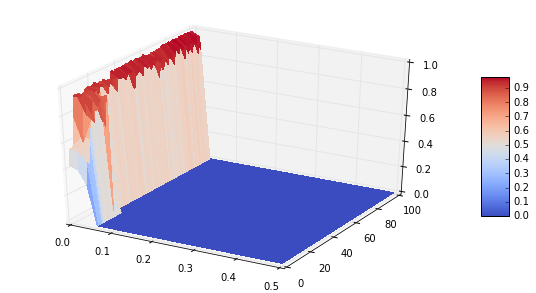

In [25]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')
X = range(0,26)
Y = range(0,100)
X, Y = np.meshgrid(X, Y)
Z = Results_sum[X, 1, 0, 3, Y]
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
vals = ax.get_xticks()
ax.set_xticklabels(CV_range[[x for x in vals]])

plt.show()


In [31]:
Results_sum[0, 1, 2, 0, :]

array([ 161.25      ,  173.75      ,  152.43055556,  123.26388889,
        135.34722222,  119.09722222,  112.91666667,  108.19444444,
        123.54166667,  110.        ,  131.38888889,  137.29166667,
        130.27777778,  127.22222222,  122.08333333,  120.90277778,
        116.25      ,  139.93055556,  122.77777778,  113.05555556,
        106.18055556,  108.19444444,  109.16666667,   97.43055556,
        115.55555556,  110.27777778,  106.94444444,  103.61111111,
        105.06944444,  110.41666667,  103.47222222,  120.69444444,
        107.77777778,   96.59722222,  101.80555556,  102.91666667,
         92.98611111,   86.94444444,  123.05555556,   97.08333333,
         95.69444444,   88.47222222,   92.08333333,   90.        ,
         87.63888889,  109.51388889,   95.41666667,   95.90277778,
         93.81944444,   87.63888889,   81.38888889,   82.43055556,
        112.63888889,   92.01388889,   93.19444444,   87.63888889,
         83.47222222,   78.81944444,   82.77777778,  100.34722

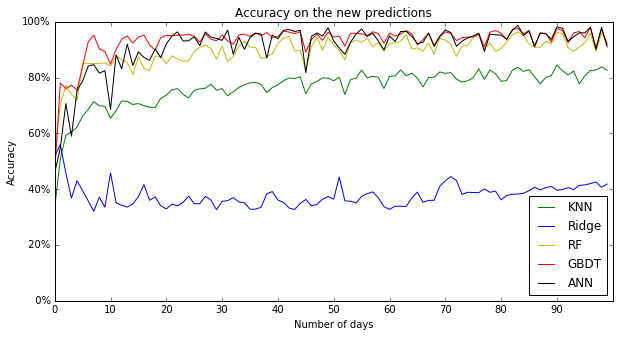

In [40]:
fig3 = plt.figure(figsize=(10,5))
ax = fig3.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2]
ax.plot(Results_sum[0, 1, 1, 0, :], label='KNN', color="g")
ax.plot(Results_sum[0, 1, 1, 1, :], label='Ridge', color="b")
ax.plot(Results_sum[0, 1, 1, 2, :], label='RF', color="y")
ax.plot(Results_sum[0, 1, 1, 3, :], label='GBDT', color="r")
ax.plot(Results_sum[0, 1, 1, 4, :], label='ANN', color="k")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of days")
ax.set_xticks(range(0, len(Results_sum[0, 1, 1, 0, :]), 10))
ax.set_xticklabels(range(ini_day, tot_day + 1, 10))
ax.legend(loc='best')
plt.title('Accuracy on the new predictions')

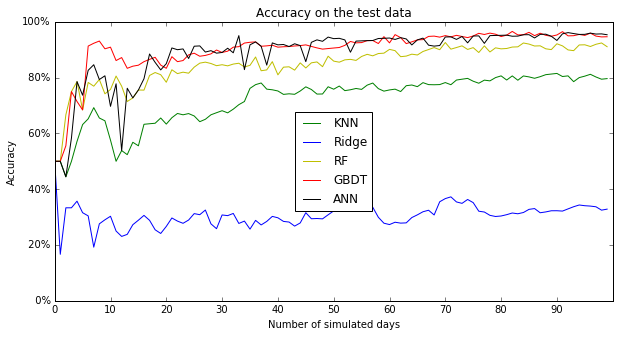

In [41]:
fig3 = plt.figure(figsize=(10,5))
ax = fig3.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2])
ax.plot(Results_sum[0, 0, 1, 0, :], label='KNN', color="g")
ax.plot(Results_sum[0, 0, 1, 1, :], label='Ridge', color="b")
ax.plot(Results_sum[0, 0, 1, 2, :], label='RF', color="y")
ax.plot(Results_sum[0, 0, 1, 3, :], label='GBDT', color="r")
ax.plot(Results_sum[0, 0, 1, 4, :], label='ANN', color="k")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of simulated days")
ax.set_xticks(range(0, len(Results_sum[0, 0, 1, 0, :]), 10))
ax.set_xticklabels(range(ini_day, tot_day + 1, 10))
ax.legend(loc='best')
plt.title('Accuracy on the test data')

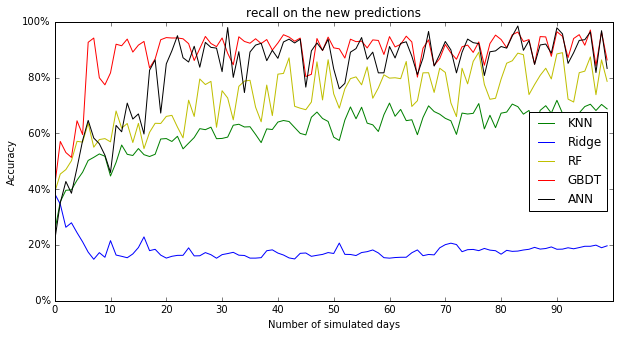

In [42]:
fig3 = plt.figure(figsize=(10,5))
ax = fig3.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2])
ax.plot(Results_sum[0, 1, 0, 0, :], label='KNN', color="g")
ax.plot(Results_sum[0, 1, 0, 1, :], label='Ridge', color="b")
ax.plot(Results_sum[0, 1, 0, 2, :], label='RF', color="y")
ax.plot(Results_sum[0, 1, 0, 3, :], label='GBDT', color="r")
ax.plot(Results_sum[0, 1, 0, 4, :], label='ANN', color="k")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of simulated days")
ax.set_xticks(range(0, len(Results_sum[0, 1, 0, 0, :]), 10))
ax.set_xticklabels(range(ini_day, tot_day + 1, 10))
ax.legend(loc='best')
plt.title('recall on the new predictions')

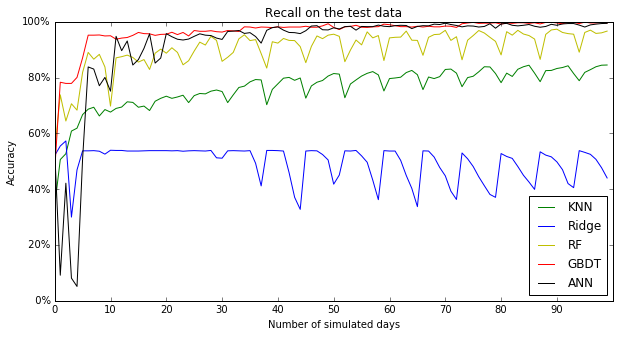

In [38]:
fig3 = plt.figure(figsize=(10,5))
ax = fig3.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2])
ax.plot(Results_sum[0, 1, 1, 0, :], label='KNN', color="g")
ax.plot(Results_sum[0, 1, 1, 1, :], label='Ridge', color="b")
ax.plot(Results_sum[0, 1, 1, 2, :], label='RF', color="y")
ax.plot(Results_sum[0, 1, 1, 3, :], label='GBDT', color="r")
ax.plot(Results_sum[0, 1, 1, 4, :], label='ANN', color="k")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of simulated days")
ax.set_xticks(range(0, len(Results_sum[0, 1, 1, 0, :]), 10))
ax.set_xticklabels(range(ini_day, tot_day + 1, 10))
ax.legend(loc='best')
plt.title('Recall on the test data')

[   0  120  240  360  480  600  720  840  960 1080 1200 1320 1440]


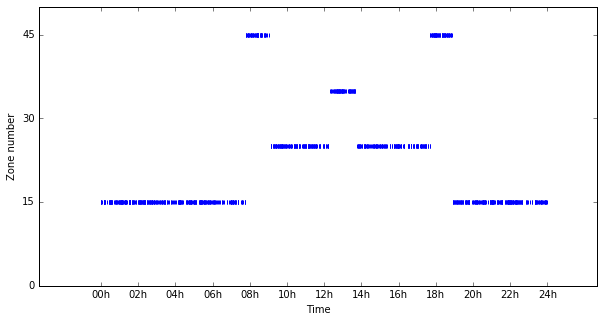

In [54]:
mobiledata_PL = mobiledata_tot[0,99].copy()
mobiledata_PL['min_acc'] = mobiledata_PL['hour'] * 60 + mobiledata_PL['minute']
fig1 = plt.figure(figsize=(10,5))
ax = fig1.add_subplot(1, 1, 1)
ax.scatter(mobiledata_PL['min_acc'], mobiledata_PL['tzone'], marker = "|")
ax.set_xticks(range(0, 1441, 1440/12))
ax.set_yticks(range(0, 46, 15))
vals = ax.get_xticks()
print vals
ax.set_xticklabels(['{:02.0f}h'.format(x/60) for x in vals])
ax.set_ylabel("Zone number")
ax.set_xlabel("Time")
# ax2.plot(mobiledata_sel['minute'], mobiledata_sel['tzone_y'])
# ax2.set_xticks(range(0, 1440, 200))
# ax2.set_yticks(range(0, 45, 15))

[   0  120  240  360  480  600  720  840  960 1080 1200 1320 1440]


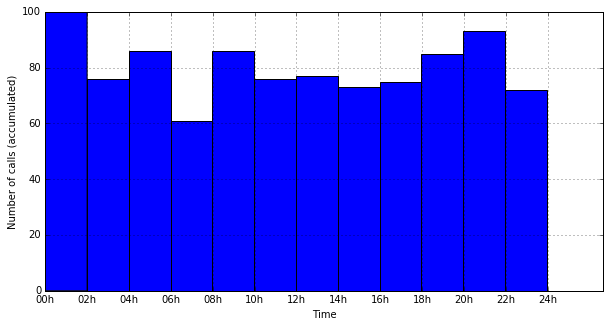

In [55]:
# checking the distribution of mobile phone calls
fig2 = plt.figure(figsize=(10,5))
ax = fig2.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2])
(mobiledata_PL['min_acc'][pd.notnull(mobiledata_PL['tzone'])]).hist(bins=12)
ax.set_xticks(range(0, 1441, 1440/12))
vals = ax.get_xticks()
print vals
ax.set_xticklabels(['{:02.0f}h'.format(x/60) for x in vals])
ax.set_ylabel("Number of calls (accumulated)")
ax.set_xlabel("Time")
#ax.set_xticks(range(0, 1440, 1440/12))
#plt.hist(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], bins=50)

In [ ]:
mobiledata_PL = mobiledata_ML.copy()
mobiledata_PL['min_acc'] = mobiledata_PL['hour'] * 60 + mobiledata_PL['minute']
print mobiledata_PL.max()
print mobiledata_PL.min()

In [ ]:
import numpy as np
import time
import theano
A = np.random.rand(1000,10000).astype(theano.config.floatX)
B = np.random.rand(10000,1000).astype(theano.config.floatX)
np_start = time.time()
AB = A.dot(B)
np_end = time.time()
X,Y = theano.tensor.matrices('XY')
mf = theano.function([X,Y],X.dot(Y))
t_start = time.time()
tAB = mf(A,B)
t_end = time.time()
print("NP time: %f[s], theano time: %f[s] (times should be close when run on CPU!)" %(
                                           np_end-np_start, t_end-t_start))
print("Result difference: %f" % (np.abs(AB-tAB).max(), ))



In [ ]:
print aa[aa['minute']==789], bb[bb['minute']==789]

In [ ]:
class User(object):
    def __init__(self, name, email):
        self.name = name
        self.email = email
    def commit(self):
        pass

jason = User('jason', 'jason@email.com')
jack = User('jack', 'jack@yahoo.com')

In [ ]:
import os
try:
    user_paths = os.environ['PYTHONPATH'].split(os.pathsep)
except KeyError:
    user_paths = []

In [ ]:
user_paths

In [ ]:
trainX, testX, trainY, testY = traintestsplit_tot[99]
pred_X, pred_y = pr_data_tot[99]

In [ ]:
#trainX.drop('acc_time', axis=1, inplace=True)
trainX.drop('day', axis=1, inplace=True)
#testX.drop('acc_time', axis=1, inplace=True)
testX.drop('day', axis=1, inplace=True)
#pred_X.drop('acc_time', axis=1, inplace=True)
pred_X.drop('day', axis=1, inplace=True)

In [ ]:
## using RF
clf_rf = RandomForestClassifier()#n_estimators=1000, max_depth=100)
clf_rf.fit(trainX, trainY)
pred_rf = clf_rf.predict(testX)
print precision_score(testY, pred_rf, average=None)
print accuracy_score(testY, pred_rf)
print recall_score(testY, pred_rf, average='macro')
print recall_score(testY, pred_rf, average='micro')
print confusion_matrix(testY, pred_rf)

pred_rf = clf_rf.predict(pred_X)
print precision_score(pred_y, pred_rf, average=None)
print accuracy_score(pred_y, pred_rf)
print recall_score(pred_y, pred_rf, average='macro')
print recall_score(pred_y, pred_rf, average='micro')
print confusion_matrix(pred_y, pred_rf)


In [ ]:
# knn
clf_knn = KNeighborsClassifier(n_neighbors=1).fit(trainX, trainY)
pred_knn = clf_knn.predict(testX)
#print roc_auc_score(testY, pred_knn)
print precision_score(testY, pred_knn, average=None)
print accuracy_score(testY, pred_knn)
print recall_score(testY, pred_knn, average='macro')
print recall_score(testY, pred_knn, average='micro')
print confusion_matrix(testY, pred_knn)

pred_knn = clf_knn.predict(pred_X)
print precision_score(pred_y, pred_knn, average=None)
print accuracy_score(pred_y, pred_knn)
print recall_score(pred_y, pred_knn, average='macro')
print recall_score(pred_y, pred_knn, average='micro')
print confusion_matrix(pred_y, pred_knn)

In [ ]:
# knn
clf_knn = KNeighborsClassifier(n_neighbors=1).fit(trainX, trainY)
pred_knn = clf_knn.predict(testX)
#print roc_auc_score(testY, pred_knn)
print precision_score(testY, pred_knn, average=None)
print accuracy_score(testY, pred_knn)
print recall_score(testY, pred_knn, average='macro')
print recall_score(testY, pred_knn, average='micro')
print confusion_matrix(testY, pred_knn)

pred_knn = clf_knn.predict(pred_X)
print precision_score(pred_y, pred_knn, average=None)
print accuracy_score(pred_y, pred_knn)
print recall_score(pred_y, pred_knn, average='macro')
print recall_score(pred_y, pred_knn, average='micro')
print confusion_matrix(pred_y, pred_knn)


In [ ]:
path = './agentdata.txt'
columnname = ["todrop", "acc_time", "day", "minute", "pid", "zone", "status", "xcor", "ycor", "tid"]
agentdata = rawimport(path, columnname)
dt_stamp = [datetime.strptime(x,  '%Y-%m-%d %H:%M') for x in agentdata["acc_time"]]
dow = [datetime.isoweekday(x) for x in dt_stamp]
hr = [x.hour for x in dt_stamp]
minu = [x.minute for x in dt_stamp]
agentdata['dow'] = dow
agentdata['hour'] = hr
agentdata['minute'] = minu


path = './mobiletowers.txt'
columnname = ["todrop", "acc_time", "day", "minute", "pid", "tpid", "tzone", "radius", "tid", "txcor", "tycor"]
mobiledata = rawimport(path, columnname)



In [ ]:
dt_stamp = []
for x in agentdata["acc_time"].values:
    dt_stamp.append(datetime.strptime(x, '%Y-%m-%d %H:%M'))
dt_stamp

In [ ]:
#'agentdata['hour'] = hr
agentdata['minute'] = minu

In [ ]:

for x in agentdata["acc_time"].values:
    print parse(x)



In [ ]:
# leave the last n day(s) out for testing purpose

#mobiledata_ML = mobiledata[mobiledata['day'] <= (mobiledata['day'].max() - last_n)]
mobiledata_ML = mobiledata.drop('radius', axis = 1)
mobiledata_ML.drop('tid', axis=1, inplace=True)
mobiledata_ML.drop('txcor', axis=1, inplace=True)
mobiledata_ML.drop('tycor', axis=1, inplace=True)

In [ ]:
# prepare for ML
X = mobiledata_ML.drop('tzone', axis=1)
y = mobiledata_ML['tzone']
trainX, testX, trainY, testY = train_test_split(X, y)

In [ ]:
#k fold cross-validation
from sklearn.cross_validation import KFold

for train_indices, test_indices in KFold(len(X), n_folds=3):
    fold_trainX = X.iloc[train_indices, :]
    fold_testX  = X.iloc[test_indices, :]
    fold_trainY = y[train_indices]
    fold_testY  = y[test_indices]
    clf_knn = KNeighborsClassifier(n_neighbors=2).fit(fold_trainX, fold_trainY)
    pred_knn = clf_knn.predict(fold_testX)
    #print roc_auc_score(testY, pred_knn)
    print precision_score(fold_testY, pred_knn, average='micro')  
    print recall_score(fold_testY, pred_knn, average='micro')
    confusion_matrix(fold_testY, pred_knn)
    #print fold_trainY



In [ ]:


# knn
clf_knn = KNeighborsClassifier(n_neighbors=1).fit(trainX, trainY)
pred_knn = clf_knn.predict(testX)
#print roc_auc_score(testY, pred_knn)
print precision_score(testY, pred_knn, average=None)
print accuracy_score(testY, pred_knn)
print recall_score(testY, pred_knn, average='macro')
print recall_score(testY, pred_knn, average='micro')
print confusion_matrix(testY, pred_knn)
cross_val_score(clf_knn, X, y, cv=3)

In [ ]:
## using ridge regression
clf_rdg = RidgeClassifier(alpha=1).fit(trainX,trainY)
pred_rdg = clf_rdg.predict(testX)
print precision_score(testY, pred_rdg, average='micro')  
print confusion_matrix(testY, pred_rdg)
cross_val_score(clf_rdg, X, y, cv=3)

In [ ]:
## using RF
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=100)
clf_rf.fit(trainX, trainY)
pred_rf = clf_rf.predict(testX)
print precision_score(testY, pred_rf, average='micro')  
print confusion_matrix(testY, pred_rf)
cross_val_score(clf_rf, X, y, cv=3)

In [ ]:
## using GBDT
clf_gb = GradientBoostingClassifier(n_estimators=100, max_depth=3)
clf_gb.fit(trainX, trainY)
pred_gb = clf_gb.predict(testX)
print precision_score(testY, pred_gb, average='micro')  
print confusion_matrix(testY, pred_gb)
cross_val_score(clf_gb, X, y, cv=3)
#test_qualities = []
# for p in clf_gb.staged_predict_proba(testX):
#     test_qualities.append(precision_score(testY, p[:, 1]))
# plt.plot(test_qualities)

In [ ]:
last_n = 1
last_minutes = last_n * (-1440)
pred_X = agentdata[last_minutes:].iloc[:,0:4]
pred_X['tpid'] = 0
pred_y = agentdata[last_minutes:].iloc[:,4]

# pred_knn = trained_clf.clf1.predict(pred_X)
# #print roc_auc_score(testY, pred_knn)
# knn_AC = accuracy_score(pred_y, pred_knn)
# knn_RC = recall_score(pred_y, pred_knn, average='macro')
# knn_CM = confusion_matrix(pred_y, pred_knn)

# ## using ridge regression
# pred_rdg = trained_clf.clf2.predict(pred_X)
# rdg_AC = accuracy_score(pred_y, pred_rdg)
# rdg_RC = recall_score(pred_y, pred_rdg, average='macro')  
# rdg_CM = confusion_matrix(pred_y, pred_rdg)

# ## using RF
# pred_rf = trained_clf.clf3.predict(pred_X)
# rf_AC = accuracy_score(pred_y, pred_rf)
# rf_RC = recall_score(pred_y, pred_rf, average='macro')  
# rf_CM = confusion_matrix(pred_y, pred_rf)

## using GBDT
pred_gb = clf_gb.predict(pred_X)
gb_AC = accuracy_score(pred_y, pred_gb)
gb_RC = recall_score(pred_y, pred_gb, average='macro')  
gb_CM = confusion_matrix(pred_y, pred_gb)

In [ ]:
gb_CM

In [ ]:
## using SVM
## solving multi-classification problem?
clf_svc = SVC()
clf_svc.fit(trainX, trainY)
pred_svc = clf_svc.predict(testX)
print precision_score(testY, pred_svc, average='micro')  
print confusion_matrix(testY, pred_svc)
cross_val_score(clf_svc, X, y, cv=3)


In [ ]:
## prediction
# pre_agent1 = mobiledata[:1]
# pre_agent = pd.concat([pre_agent1]*1440)
# pre_agent['day']=mobiledata['day'].max()+1
# pre_agent['minute']=range(0,1440)
# pre_agent['acc_time']=pre_agent['minute'] + pre_agent['day']*1440
# pre_agent.drop('tzone', axis=1, inplace=True)
# pre_agent.drop('radius', axis=1, inplace=True)
# pre_agent.drop('tid', axis=1, inplace=True)
# pre_agent.drop('txcor', axis=1, inplace=True)
# pre_agent.drop('tycor', axis=1, inplace=True)
pred_X = agentdata[-1440:].iloc[:,0:4]
pred_X['tpid'] = 0
pred_y = agentdata[-1440:].iloc[:,4]


In [ ]:

pred_knn = clf_knn.predict(pred_X)
#print roc_auc_score(testY, pred_knn)
knn_PR = precision_score(pred_y, pred_knn, average='micro')
knn_CM = confusion_matrix(pred_y, pred_knn)

## using ridge regression
pred_rdg = clf_rdg.predict(pred_X)
rdg_PR = precision_score(pred_y, pred_rdg, average='micro')  
rdg_CM = confusion_matrix(pred_y, pred_rdg)

## using RF
pred_rf = clf_rf.predict(pred_X)
rf_PR = precision_score(pred_y, pred_rf, average='micro')  
rf_CM = confusion_matrix(pred_y, pred_rf)

## using GBDT
pred_gb = clf_gb.predict(pred_X)
gb_PR = precision_score(pred_y, pred_gb, average='micro')  
gb_CM = confusion_matrix(pred_y, pred_gb)

print knn_PR, rdg_PR, rf_PR, gb_PR


In [ ]:
pred_gb






In [ ]:
pre_agent

In [ ]:
# prepare for ML
X = mobiledata_fs_filled.drop('zone', axis=1)
y = mobiledata_fs_filled['zone']
trainX, testX, trainY, testY = train_test_split(X, y)

## using KNN
# weights might need to be changed - more weights towards the recent data?
# metrics? canberra, minkowski
clf_knn = KNeighborsClassifier(n_neighbors=1).fit(trainX, trainY)
pred_knn = clf_knn.predict(testX)
#print roc_auc_score(testY, pred_knn)
knn_PR = precision_score(testY, pred_knn, average='micro')
knn_CM = confusion_matrix(testY, pred_knn)

## using ridge regression
clf_rdg = RidgeClassifier(alpha=1).fit(trainX,trainY)
pred_rdg = clf_rdg.predict(testX)
rdg_PR = precision_score(testY, pred_rdg, average='micro')  
rdg_CM = confusion_matrix(testY, pred_rdg)

## using RF
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=10)
clf_rf.fit(trainX, trainY)
pred_rf = clf_rf.predict(testX)
rf_PR = precision_score(testY, pred_rf, average='micro')  
rf_CM = confusion_matrix(testY, pred_rf)

## using GBDT
clf_gb = GradientBoostingClassifier(n_estimators=100, max_depth=3)
clf_gb.fit(trainX, trainY)
pred_gb = clf_gb.predict(testX)
gb_PR = precision_score(testY, pred_gb, average='micro')  
gb_CM = confusion_matrix(testY, pred_gb)

In [ ]:
#class ReturnValue(object):
#    def __init__(self, y0, y1):
#        self.y0 = y0
#        self.y1 = y1

def data_input():
    path = './agentdata.txt'
    columnname = ["todrop", "acc_time", "day", "minute", "pid", "zone", "status", "xcor", "ycor", "tid"]
    agentdata = rawimport(path, columnname)
    
    path = './mobiletowers.txt'
    columnname = ["todrop", "acc_time", "day", "minute", "pid", "tpid", "tzone", "radius", "tid", "txcor", "tycor"]
    mobiledata = rawimport(path, columnname)
    
    # extend data to full (missing data shown as NaN)
    mobiledata = mobiledata.drop(labels = ["tid"], axis=1)

    mobiledata_fs = pd.merge(agentdata, mobiledata, how = 'left', on = ["acc_time", 'day', 'minute', "pid"])
    #mobiledata_fs = pd.merge(agentdata_ri, mobiledata_ri, how = 'left', left_index = True, right_index = True)
    #print mobiledata_fs.count()
    #mobiledata_fs
# fill the missing data using NN (k=1)
# the reason why "day" and "minute" need to be removed before imputation is that the imputation is done based on features.
# in other words, the day and minute will have impacts on the imputed results
# to maintain a continuity of a user between days it is necessary to remove "day" and "minute" before imputation and add them back later
# also no need to imputate tower id
    mobiledata_fs_test = mobiledata_fs.drop(labels = ["day"], axis=1)
    mobiledata_fs_test = mobiledata_fs_test.drop(labels = ["minute"], axis=1)
    mobiledata_fs_test = mobiledata_fs_test.drop(labels = ["tid"], axis=1)
    mobiledata_fs_filled = KNN(k=1).complete(mobiledata_fs_test)
    mobiledata_fs_filled = pd.DataFrame(mobiledata_fs_filled, columns = ["acc_time", "pid", "zone", 
                                                                     "status", "xcor", "ycor", "tpid", "tzone", 
                                                                     "radius", "txcor", "tycor"])
# add the day and minute information back
    mobiledata_daymin = mobiledata_fs.ix[:,[0, 1, 2, 3, 8]]
    mobiledata_fs_filled = pd.merge(mobiledata_daymin, mobiledata_fs_filled, how = 'left', on = ["acc_time", "pid"])
    mobiledata_cp = pd.merge(mobiledata_fs, mobiledata_fs_filled, how = 'left', on = ["acc_time", 'day', 'minute', "pid"])
    mobiledata_fs_filled.fillna(-1, inplace=True)
    
    return (mobiledata_fs, mobiledata_fs_filled, mobiledata_cp)

In [ ]:
#run_NL()

mobiledata_fs, mobiledata_fs_filled, mobiledata_cp = data_input()
#miss_imput()

In [ ]:
print mobiledata_fs_filled.count()

In [ ]:
mobiledata_fs_filled.zone.max()


In [ ]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
mobiledata_sel = mobiledata_cp[mobiledata_cp['day'] == 0]
ax1.scatter(mobiledata_sel['minute'], mobiledata_sel['tzone_x'])
ax1.set_xticks(range(0, 1440, 200))
ax1.set_yticks(range(0, 45, 15))
ax2.plot(mobiledata_sel['minute'], mobiledata_sel['tzone_y'])
ax2.set_xticks(range(0, 1440, 200))
ax2.set_yticks(range(0, 45, 15))

In [ ]:
# checking the distribution of mobile phone calls
fig2 = plt.figure(figsize=(10,5))
ax = fig2.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2])
(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])]).hist(bins=12)
#plt.hist(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], bins=50)

In [ ]:
# ML
def NL_ML(mobiledata_fs_filled):
    # prepare for ML
    X = mobiledata_fs_filled.drop('zone', axis=1)
    y = mobiledata_fs_filled['zone']
    trainX, testX, trainY, testY = train_test_split(X, y)
    
    ## using KNN
    # weights might need to be changed - more weights towards the recent data?
    # metrics? canberra, minkowski
    clf_knn = KNeighborsClassifier(n_neighbors=1).fit(trainX, trainY)
    pred_knn = clf_knn.predict(testX)
    #print roc_auc_score(testY, pred_knn)
    knn_PR = precision_score(testY, pred_knn, average='micro')
    knn_CM = confusion_matrix(testY, pred_knn)
    
    ## using ridge regression
    clf_rdg = RidgeClassifier(alpha=1).fit(trainX,trainY)
    pred_rdg = clf_rdg.predict(testX)
    rdg_PR = precision_score(testY, pred_rdg, average='micro')  
    rdg_CM = confusion_matrix(testY, pred_rdg)
    
    ## using RF
    clf_rf = RandomForestClassifier(n_estimators=100, max_depth=10)
    clf_rf.fit(trainX, trainY)
    pred_rf = clf_rf.predict(testX)
    rf_PR = precision_score(testY, pred_rf, average='micro')  
    rf_CM = confusion_matrix(testY, pred_rf)
    
    ## using GBDT
    clf_gb = GradientBoostingClassifier(n_estimators=100, max_depth=3)
    clf_gb.fit(trainX, trainY)
    pred_gb = clf_gb.predict(testX)
    gb_PR = precision_score(testY, pred_gb, average='micro')  
    gb_CM = confusion_matrix(testY, pred_gb)
    
    return (knn_PR, knn_CM, rdg_PR, rdg_CM, rf_PR, rf_CM, gb_PR, gb_CM)

In [ ]:
fig3 = plt.figure(figsize=(10,5))
ax = fig3.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2])
ax.plot(knn_all_PR, label='NN', color="g")
ax.plot(rdg_all_PR, label='Ridge', color="b")
ax.plot(rf_all_PR, label='RF', color="y")
ax.plot(gb_all_PR, label='GBDT', color="r")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylabel("precision")
ax.set_xlabel("Call Frequency - number of calls per day")
ax.set_xticklabels(range(1,10))
ax.legend(loc='best')

In [ ]:
knn_all_PR

In [ ]:
t = NL_ML(comdata_fs_filled)

In [ ]:
print gb_all_PR


In [ ]:
print t


In [ ]:
# prepare for ML

X = mobiledata_fs_filled.drop('zone', axis=1)
y = mobiledata_fs_filled['zone']

trainX, testX, trainY, testY = train_test_split(X, y)


In [ ]:
## using KNN
# weights might need to be changed - more weights towards the recent data?
# metrics? canberra, minkowski


clf_knn = KNeighborsClassifier(n_neighbors=1).fit(trainX, trainY)
pred_knn = clf_knn.predict(testX)
#print roc_auc_score(testY, pred_knn)
print precision_score(testY, pred_knn, average='micro')  
print recall_score(testY, pred_knn, average='micro')
confusion_matrix(testY, pred_knn)

In [ ]:
pred_knn.shape

In [ ]:
testX, pred_knn

In [ ]:
## using Ridge

clf_rdg = RidgeClassifier(alpha=1).fit(trainX,trainY)
pred_rdg = clf_rdg.predict(testX)
print precision_score(testY, pred_rdg, average='micro')  
print recall_score(testY, pred_rdg, average='micro')
confusion_matrix(testY, pred_rdg)

In [ ]:
## using Lasso

clf_las = Lasso(alpha=1).fit(trainX,trainY)
pred_las = clf_las.predict(testX)
print precision_score(testY, pred_las, average='micro')  
print recall_score(testY, pred_las, average='micro')
confusion_matrix(testY, pred_las)

In [ ]:
## using RF

clf_rf = RandomForestClassifier(n_estimators=100, max_depth=10)
clf_rf.fit(trainX, trainY)
pred_rf = clf_rf.predict(testX)
print precision_score(testY, pred_rf, average='micro')  
print recall_score(testY, pred_rf, average='micro')
confusion_matrix(testY, pred_rf)

In [ ]:
## using GBDT

clf_gb = GradientBoostingClassifier(n_estimators=100, max_depth=3)
clf_gb.fit(trainX, trainY)
pred_gb = clf_gb.predict(testX)
print precision_score(testY, pred_gb, average='micro')  
print recall_score(testY, pred_gb, average='micro')
confusion_matrix(testY, pred_gb)

In [ ]:
def fit_predict_NNa(trainX, trainY, testX, activate_functions, hidden_layers, reg_lambda):
    X_ = theano.shared(trainX, name='X')
    y_ = theano.shared(trainY, name='y')
    param = T.vector()
    dim = X.shape[1]
    num_examples = X.shape[0]
    dim_y = len(np.unique(trainY))
    def activation(data_, parameter):
        n_previous = 0
        dim_previous = dim
        h = data_
        #going through hidden layers
        for n_hidden, func in zip(hidden_layers, activate_functions):
            N = dim_previous * n_hidden
            W_ = parameter[n_previous:n_previous + N].reshape((dim_previous, n_hidden))
            h = func(h.dot(W_))
            dim_previous = n_hidden
            n_previous += N

        # output     
        N = dim_previous * dim_y
        v_ = parameter[n_previous:n_previous + N].reshape((dim_previous, dim_y))
        output = h.dot(v_)
        n_previous += N
        return T.nnet.softmax(output), n_previous

    y_hat, dim_W = activation(X_, param)
    # optimize
    #regularisation
    loss_reg = 1./num_examples * reg_lambda/2 * T.sum(T.sqr(param)) 
    #cost
    loss = T.nnet.categorical_crossentropy(y_hat, y_).mean() + loss_reg
    loss_function = theano.function([param], loss)
    loss_grad = theano.function([param], theano.grad(loss, param))
    
    result = minimize(loss_function, jac=loss_grad, x0=np.random.normal(size=activation(X_, param)[1]))
    optimal_params = result['x']
#    print result
    forward_prop = theano.function([param], y_hat)
    theano.printing.pydotprint(forward_prop, var_with_name_simple=True, compact=True, outfile='img/nn-theano-forward_prop.png', format='png')
    SVG(theano.printing.pydotprint(forward_prop, var_with_name_simple=True, compact=True, return_image=True, format='svg'))

    # predict data
    data = T.matrix()
#    compiled_activation = theano.function([data, param], activation(data, param)[0])
    
    prediction = T.argmax(activation(data, param)[0], axis=1)
    predict = theano.function([data, param], prediction)
    return predict(testX, optimal_params)

In [ ]:
## define activation function
#sigmoid (which we used, T.nnet.sigmoid)
#leaky ReLU (defined below)
#softplus (T.nnet.softplus)

def LeakyReLU(x):
    return T.switch(x > 0, x, 0.5 * x)


In [ ]:
from sklearn.datasets import make_blobs, make_moons
from IPython.display import Image
X, y = make_moons(n_samples=20000, noise=0.1)
trainX, testX, trainY, testY = train_test_split(X, y, train_size=0.5, random_state=42)

In [ ]:
trainX, testX, trainY, testY = traintestsplit_tot[0, 99]

In [ ]:
X = np.vstack((trainX.values, testX.values))

In [ ]:
# X_ = T.matrix('X') # matrix of doubles
# y_ = T.lvector('y') # vector of int64

pred = fit_predict_NN(trainX.values, trainY_.values, testX.values, [T.tanh]*2, [10, 5], 0.5)
#roc_auc_score(testY_, pred)
print precision_score(testY_, pred, average='micro')
print recall_score(testY_, pred, average='micro')
pred_ = pred.copy()
pred_[pred==0] = 15
pred_[pred==1] = 25
pred_[pred==2] = 35
pred_[pred==3] = 45
pred_

In [ ]:
pred

In [ ]:
train_y

In [ ]:
import sklearn.datasets
#train_X, train_y = sklearn.datasets.make_moons(200, noise=0.20)
X, y = sklearn.datasets.make_blobs(200, n_features=2, centers=3)
train_X, test_X, train_y, test_y = train_test_split(X, y)
# train_X = train_X.astype(np.float32)
# train_y = train_y.astype(np.int32)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

In [ ]:
print train_X.shape, train_y.shape

In [ ]:
pred = fit_predict_NN(train_X, train_y, test_X, [T.tanh], [100])
print precision_score(test_y, pred, average='micro')
print recall_score(test_y, pred, average='micro')

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
aa = trainY.as_matrix()
bb = aa.reshape((aa.shape[0], 1))
trainY_ = MultiLabelBinarizer().fit_transform(bb)


In [ ]:
trainY_

In [ ]:
trainY_ = np.tile(np.zeros((1,4)), (trainY.shape[0],1))
trainY_[trainY == 15] = [[1, 0, 0, 0]]
# trainY_[trainY == 25] = [0, 1, 0, 0]
# trainY_[trainY == 35] = [0, 0, 1, 0]
# trainY_[trainY == 45] = [0, 0, 0, 1]
trainY_

In [ ]:
import numpy as np
import time
import theano
A = np.random.rand(1000,10000).astype(theano.config.floatX)
B = np.random.rand(10000,1000).astype(theano.config.floatX)
np_start = time.time()
AB = A.dot(B)
np_end = time.time()
X,Y = theano.tensor.matrices('XY')
mf = theano.function([X,Y],X.dot(Y))
t_start = time.time()
tAB = mf(A,B)
t_end = time.time()
print("NP time: %f[s], theano time: %f[s] (times should be close when run on CPU!)" %(
                                           np_end-np_start, t_end-t_start))
print("Result difference: %f" % (np.abs(AB-tAB).max(), ))